# Convolutional Neural Network applied to Transient Detection

We star by reading the data

In [1]:
import numpy as np

pkl_data = np.load("data/HiTS_data.pkl", encoding='bytes')
#pkl_data = np.load("/Users/guille/Dropbox/git/Deep-HiTS/data/test_data/chunk_101_5000.pkl")
print(pkl_data.keys())
print(pkl_data[b'diff_images'].shape)


dict_keys([b'SNRs', b'RF_pbbs', b'features', b'temp_images', b'sci_images', b'labels', b'diff_images', b'SNR_images'])
(5026, 441)


Now we arrange the data so Keras can handle it

In [2]:
N_data = pkl_data[b'diff_images'].shape[0]
print(N_data)
X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
             pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
             pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
             pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
X = np.swapaxes(X, 0, 1)

Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
print(X.shape, Y.shape)

5026
(5026, 4, 21, 21) (5026, 2)


In [3]:
a = np.array([[1,2,3],[4,5,6]])
print(a.transpose())
print(a.reshape ((3, 2)))

[[1 4]
 [2 5]
 [3 6]]
[[1 2]
 [3 4]
 [5 6]]


Let's plot a couple of stamps

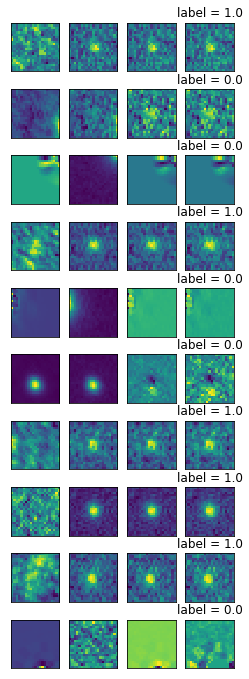

In [4]:
%matplotlib inline
import pylab as pl

N_plot = 10

pl.clf()
fig, axes = pl.subplots(N_plot, 4, figsize=(4, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(N_plot):
    axes.flat[4*i].imshow(X[i][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X[i][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X[i][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X[i][3], interpolation = "none")
    #axes.flat[4*i + 3].imshow(pkl_data['diff_images'][i].reshape((21, 21)), interpolation = "nearest")

    axes.flat[4*i + 3].set_title ("label = " + str(Y[i][1]))
pl.show()


We split the data into training, and test set.

In [52]:
N_train = int(N_data * 0.9)

X_train, Y_train = X[:N_train], Y[:N_train]
X_test, Y_test = X[N_train:], Y[N_train:]

print("Train: ", X_train.shape, Y_train.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (4523, 4, 21, 21) (4523, 2)
Test:  (503, 4, 21, 21) (503, 2)


We create a Keras sequential model and compile it.

In [130]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

def make_model(compile=True):
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
    model.add(Convolution2D(32, (4, 4), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    
    if compile:
        model.compile(loss='mean_squared_error',
              optimizer='sgd', metrics=['accuracy'])

        # initiate RMSprop optimizer (OLD)
        #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

        # Compile model
        # epochs = 25
        # lrate = 0.01
        # decay = lrate/epochs
        # opt = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

        # # Let's train the model using RMSprop
        # model.compile(loss='mean_squared_error', #categorical_crossentropy',
        #               optimizer=opt,
        #               metrics=['accuracy'])

    return model

In [134]:
model = make_model()

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Let's plot the model

To get this to plot, need to install (via pip --user or conda):
    
    1. graphviz
    2. pydot-ng

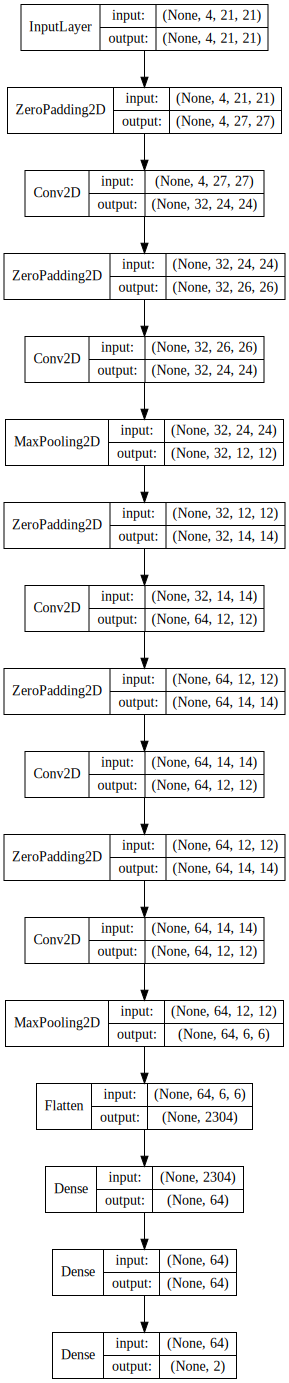

In [132]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [133]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_72 (ZeroPaddi (None, 4, 27, 27)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 32, 24, 24)        2080      
_________________________________________________________________
zero_padding2d_73 (ZeroPaddi (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 12, 12)        0         
_________________________________________________________________
zero_padding2d_74 (ZeroPaddi (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 64, 12, 12)        18496     
__________

Now, we fit our model to the training data-set

In [97]:
model.fit(X_train, Y_train, batch_size=32, epochs=25, validation_split=0.2,
         shuffle=True, callbacks=[early_stopping])

Train on 3618 samples, validate on 905 samples
Epoch 1/25
3618/3618 [==============================] - 26s - loss: 0.0910 - acc: 0.9143 - val_loss: 0.0456 - val_acc: 0.9525
Epoch 2/25
3618/3618 [==============================] - 27s - loss: 0.0785 - acc: 0.9176 - val_loss: 0.0352 - val_acc: 0.9602
Epoch 3/25
3618/3618 [==============================] - 28s - loss: 0.0266 - acc: 0.9726 - val_loss: 0.0297 - val_acc: 0.9713
Epoch 4/25
3618/3618 [==============================] - 27s - loss: 0.0238 - acc: 0.9743 - val_loss: 0.0285 - val_acc: 0.9691
Epoch 5/25
3618/3618 [==============================] - 27s - loss: 0.0213 - acc: 0.9784 - val_loss: 0.0503 - val_acc: 0.9359
Epoch 6/25
3618/3618 [==============================] - 27s - loss: 0.0217 - acc: 0.9782 - val_loss: 0.0265 - val_acc: 0.9702
Epoch 7/25
3618/3618 [==============================] - 27s - loss: 0.0219 - acc: 0.9773 - val_loss: 0.0255 - val_acc: 0.9713
Epoch 8/25
3618/3618 [==============================] - 25s - loss: 0.0

In [98]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

503/503 [==============================] - 1s     
Test loss: 0.00310637901124
Test accuracy: 0.996023856859


In [99]:
from sklearn import metrics
pred = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred))

503/503 [==============================] - 1s     
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       252
          1       1.00      1.00      1.00       251

avg / total       1.00      1.00      1.00       503



Now, lets plot the ones that it got wrong.

In [100]:
ypred = pred
ytest = Y_test[:, 1].astype(int)

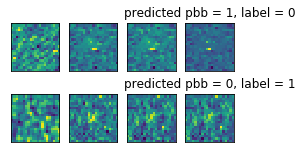

In [104]:
N_plot = 10
only_plot_wrong = True
if not only_plot_wrong:
    plot_inds = range(N_plot)
else:
    plot_inds = np.where(ypred != ytest)[0]
    if len(plot_inds) > N_plot:
        plot_inds = plot_inds[:N_plot]
N_plot = len(plot_inds)

pl.clf()
fig, axes = pl.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                        subplot_kw={'xticks': [], 'yticks': []})
i = 0
for ind in plot_inds:
    axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

    axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                  ", label = " + str(ytest[ind]))
    i += 1
pl.show()

Try again with data augmentation...

First break up data into train/cross-validation/test sets...

TBD: probably want to shuffle the data too.

In [155]:
N_train = int(N_data * 0.72)
N_valid = int(N_data * 0.86)
N_test  = int(N_data * 1.0)

X_train, Y_train = X[:N_train], Y[:N_train]
X_valid, Y_valid = X[N_train:N_valid], Y[N_train:N_valid]
X_test, Y_test = X[N_valid:N_test], Y[N_valid:N_test]

print("Train: ", X_train.shape, Y_train.shape)
print("Valid: ", X_valid.shape, Y_valid.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (3618, 4, 21, 21) (3618, 2)
Valid:  (704, 4, 21, 21) (704, 2)
Test:  (704, 4, 21, 21) (704, 2)


In [156]:
seed = 666
np.random.seed(seed)

batch_size = 32
epochs = 25   # Probably want to stop around 75 but now we have auto-stopping
data_augmentation = True

In [157]:
def run_model(model, data_augmentation=True):
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(X_train, Y_train, batch_size=batch_size, 
                  epochs=epochs, validation_data=(X_valid, Y_valid),
                  shuffle=True, callbacks=[early_stopping])
    else:
        print('Using real-time data augmentation.')
        from keras.preprocessing.image import ImageDataGenerator
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(X_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                            epochs=epochs, validation_data=(X_valid, Y_valid),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=[early_stopping]) 
        
    return model

In [ ]:
model = make_model()
model = run_model(model, data_augmentation=False)

Not using data augmentation.
Train on 3618 samples, validate on 704 samples
Epoch 1/25
3618/3618 [==============================] - 25s - loss: 0.1112 - acc: 0.9088 - val_loss: 0.0438 - val_acc: 0.9616
Epoch 2/25
3618/3618 [==============================] - 26s - loss: 0.0347 - acc: 0.9630 - val_loss: 0.0395 - val_acc: 0.9531
Epoch 3/25
3618/3618 [==============================] - 27s - loss: 0.0278 - acc: 0.9688 - val_loss: 0.0414 - val_acc: 0.9503
Epoch 4/25
3296/3618 [==========================>...] - ETA: 2s - loss: 0.0234 - acc: 0.9718

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model = make_model()
model = run_model(model, data_augmentation=True)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])